# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')



Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Runs

In [4]:
runs = {
    # 246: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 247: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 248: {'A': 0,  'WS': 2, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 249: {'A': 0,  'WS': 4, 'C': 2, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 316: {'A': 45, 'WS': 2, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 318: {'A': 45, 'WS': 4, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 317: {'A': 0,  'WS': 2, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    # 319: {'A': 0,  'WS': 4, 'C': 3, 'starts': [40000, 160000], 'stops': [119000, 240000], 'delT': [0, 5], 'SS': [True, True]},

    253: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 160000], 'stops': [110000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    254: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 160000], 'stops': [110000, 240000], 'delT': [0, 5], 'SS': [True, True]},
    321: {'A': 45, 'WS': 2, 'C': 3, 'starts': [40000, 160000], 'stops': [110000, 240000], 'delT': [0, 5], 'SS': [True, True]},

}

plotFolder = f"{home_dir}/CHARLES/multiPlots/"

qoisOutputed = ["mag(u)_avg", "mag(u)_rms", "comp(u_rms,0)", "comp(u_rms,1)", "comp(u_rms,2)", "comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]

In [5]:
allABLVolStats = {}
overWrite = False
for run in runs:
    C = runs[run]['C']
    category = f"config{C}"
    R = run % 100
    probes_dir = f'{scratch_dir}/CHARLES/{category}/R{R}/probes/probesOut'
    oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{R}/probes/probesOut_parquet/'
    print(R)
    starts = runs[run]['starts']
    stops = runs[run]['stops']
    delT = runs[run]['starts']
    SS = runs[run]['SS']
    if len(set([len(starts), len(stops), len(delT), len(SS)])) != 1:
        raise Exception(f"Run {runs} has array properties of different lengths")
    for j, start in enumerate(starts):
        stop = stops[j]
        ABLVolStatsPath = f"{oak_probes_dir}/../ABLVolStats-{start}to{stop}.csv"
        paths = [ABLVolStatsPath]
        for path in paths:
            if os.path.exists(path) == False or overWrite:
                print(f"Creating stats for {run} from step {stop}. Saving to {path}...")
                if j ==0:
                    print(f"reading probes from {oak_probes_dir}")
                    file_type = "csv"
                    probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = file_type, probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, name_pattern = "VolProbe")
                    # continue
                stats = probes.statistics(
                    names = probes.probe_names, 
                    steps = [stop],
                    quants = qoisOutputed,
                    processing = None,
                    parrallel=False
                )
                display(stats)
                stats.to_csv(ABLVolStatsPath)

        ABLVolStats = pd.read_csv(ABLVolStatsPath, index_col=0)
        for k, v in runs[run].items():
            if isinstance(v, list):
                ABLVolStats[k] = v[j]
            else:
                ABLVolStats[k] = v

        allABLVolStats[int(10*run + j)] = ABLVolStats

ABLVolStatsMI = pd.concat(allABLVolStats.values(), keys=allABLVolStats.keys())
            


53
54
21
Creating stats for 321 from step 110000. Saving to /oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config3/R21/probes/probesOut_parquet//../ABLVolStats-40000to110000.csv...
reading probes from /oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config3/R21/probes/probesOut_parquet/
processing data took 36 seconds


,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms
VolProbe0_0-0,0.435585,-0.002121,0.395488,0.336080,0.138214,0.318877,0.791502,0.308010
VolProbe0_0-1,0.539145,-0.008835,0.389679,0.371537,0.162272,0.346060,0.917437,0.338409
VolProbe0_0-2,0.343349,-0.003268,0.718413,0.351532,0.163444,0.362844,1.002460,0.344547
VolProbe0_0-3,0.216103,0.001522,0.708802,0.323649,0.166842,0.352219,0.925758,0.327581
VolProbe0_1-0,0.392058,0.000329,0.400807,0.348821,0.156179,0.342235,0.799248,0.318850
...,...,...,...,...,...,...,...,...
VolProbe9_2-3,1.122513,-0.032656,1.208152,0.379869,0.271126,0.347441,1.706552,0.393151
VolProbe9_3-0,1.279964,-0.041218,1.323670,0.397818,0.279712,0.371000,1.897117,0.423622
VolProbe9_3-1,1.121966,-0.024823,1.393834,0.394699,0.296021,0.383992,1.850646,0.419123
VolProbe9_3-2,0.812907,0.048630,1.061996,0.381696,0.291152,0.397765,1.418114,0.423942


Creating stats for 321 from step 240000. Saving to /oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config3/R21/probes/probesOut_parquet//../ABLVolStats-160000to240000.csv...
processing data took 34 seconds


,"comp(u_avg,0)","comp(u_avg,1)","comp(u_avg,2)","comp(u_rms,0)","comp(u_rms,1)","comp(u_rms,2)",mag(u)_avg,mag(u)_rms
VolProbe0_0-0,0.446090,-0.002099,0.411285,0.354295,0.144976,0.336146,0.822782,0.329777
VolProbe0_0-1,0.544865,-0.008702,0.406005,0.384148,0.169505,0.367064,0.944215,0.353837
VolProbe0_0-2,0.352587,-0.003482,0.723426,0.362494,0.169132,0.378389,1.017727,0.356993
VolProbe0_0-3,0.243508,0.001917,0.698565,0.339801,0.174011,0.370582,0.939991,0.341594
VolProbe0_1-0,0.398563,-0.000184,0.421087,0.360666,0.161002,0.359957,0.822653,0.332846
...,...,...,...,...,...,...,...,...
VolProbe9_2-3,1.168226,-0.032212,1.259581,0.396450,0.281397,0.394635,1.779213,0.435713
VolProbe9_3-0,1.335320,-0.043837,1.397308,0.402021,0.293114,0.410726,1.992154,0.444910
VolProbe9_3-1,1.142530,-0.021374,1.405450,0.418310,0.303307,0.398157,1.876370,0.440569
VolProbe9_3-2,0.887646,0.043258,1.132478,0.432037,0.305493,0.437063,1.523383,0.484766


In [6]:
def processVolProbeNames(s, pos = None):
    # Filter out any characters that are not digits, a decimal point, or a negative sign
    filtered = ''.join(c for c in s if c.isdigit() or c == '.' or c == '_')
    filtered = filtered.split('_')
    
    # Convert the filtered string to float
    if filtered:
        if pos is not None:
            return float(filtered[1][pos])
        else:
            return float(''.join(filtered[0]))

In [7]:
ABLFits = pd.DataFrame(columns=["uStar", "z0", "disp"])
for i, (k, stats) in enumerate(allABLVolStats.items()):
    # stats = df.copy()
    stats["lowerBound"] = stats.index.map(lambda s: processVolProbeNames(s))
    stats["xPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=0))
    stats["zPos"] = stats.index.map(lambda s: processVolProbeNames(s, pos=1))
    stats.sort_values(by = ["xPos", "zPos", "lowerBound"], inplace=True)

    upperBound = stats["lowerBound"].copy()
    upperBound = upperBound.shift(-1)

    if stats["C"].iloc[0] == 2:
        H = 77.3
    elif stats["C"].iloc[0] == 3:
        H = 116
    else:
        raise Exception("Configuration {category} not an option")
    upperBound.fillna(H, inplace = True)
    upperBound[upperBound == min(stats["lowerBound"])] = H
    stats["upperBound"] = upperBound
    stats.dropna(inplace=True)
    stats["y"] = (stats["lowerBound"] + stats["upperBound"]) / 2

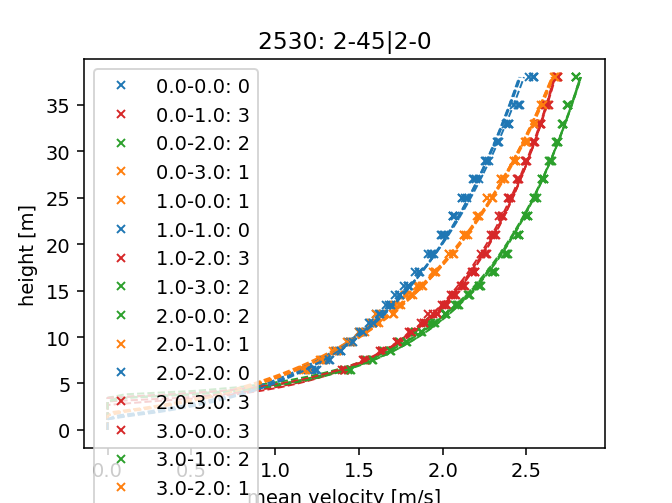

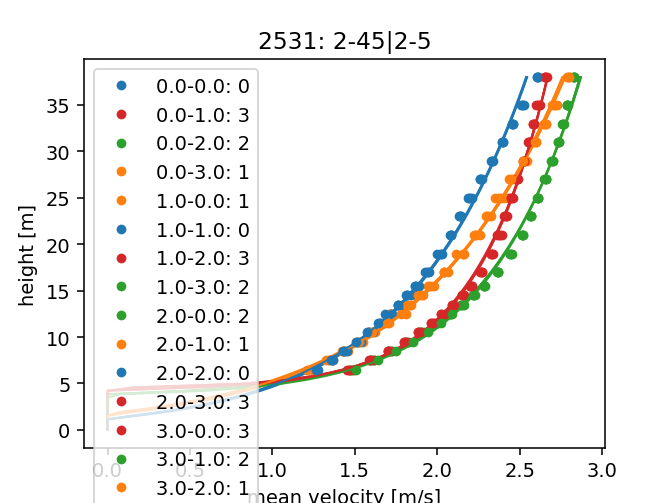

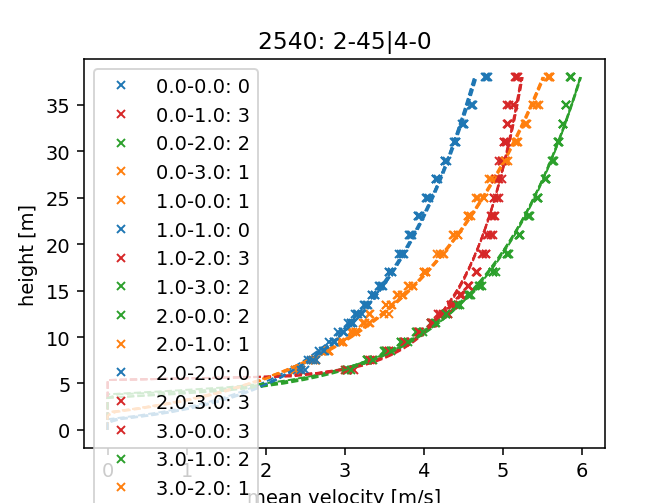

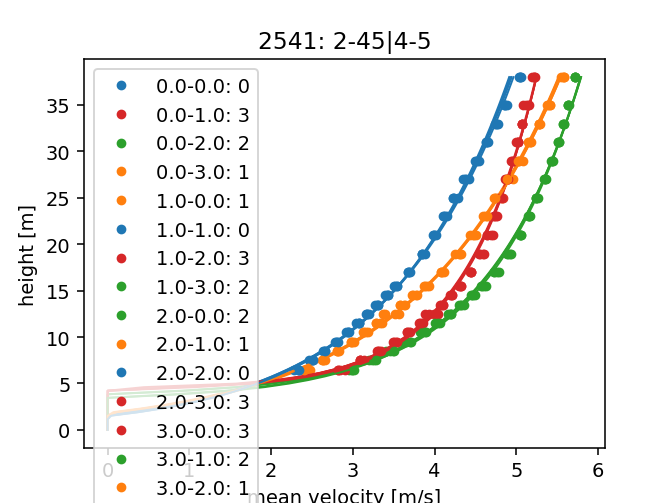

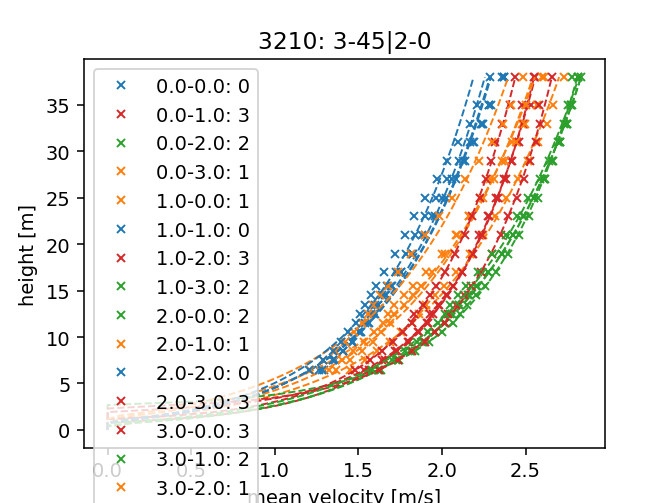

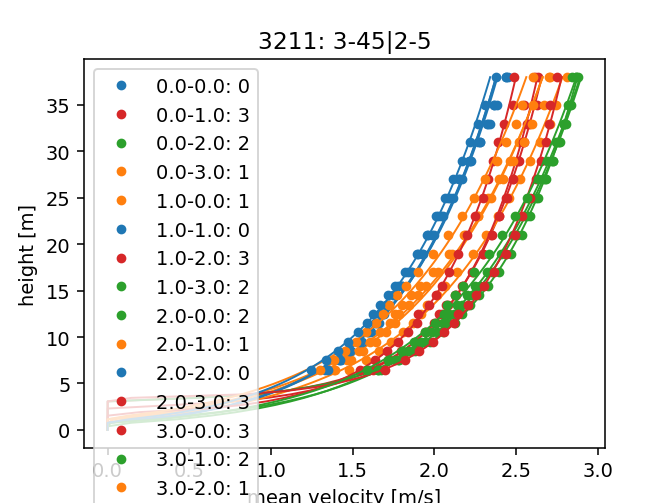

In [8]:
fmts = ['x', 'o']
styles = ['--', '-']
plt.close()
for i, (k, stats) in enumerate(allABLVolStats.items()):
    fig, ax = plt.subplots()
    A = stats["A"].iloc[0]
    C = stats["C"].iloc[0]
    WS = stats["WS"].iloc[0]
    delT = stats["delT"].iloc[0]
    ax.set_title(f"{k}: {C}-{A}|{WS}-{delT}")
    qty_vol = quantities.Qty()
    theta = stats["A"].iloc[0]
    thetaRad = theta / 180 * np.pi
    meanU = np.cos(thetaRad) * stats["comp(u_avg,0)"] + np.sin(thetaRad) * stats["comp(u_avg,2)"]
    statsMI = stats.set_index(["xPos", "zPos", "y"])
    c = 0
    fmt = fmts[int(k%2)]
    style = styles[int(k%2)]
    for xPos, dfx in statsMI.groupby(level=0):
        for zPos, df in dfx.groupby(level=1):
            qty_vol = quantities.Qty()
            # meanU = np.cos(thetaRad) * df["comp(u_avg,0)"] + np.sin(thetaRad) * df["comp(u_avg,2)"]
            meanU = df["mag(u)_avg"]
            # meanU = np.arctan(df["comp(u_avg,2)"] / df["comp(u_avg,0)"]) * 180 / np.pi
            qty_vol.meanU = meanU.iloc[6:27]
            qty_vol.y = df.index.get_level_values(2).values[6:27]
            if A == 45:
                id = int((xPos-zPos)%4)
            elif A == 0:
                id = int(zPos)
            ax = quantities.plot_ABL({f"{xPos}-{zPos}: {id}": qty_vol}, fit_disp=True, colorOffset=id, ax=ax, fmt = fmt, linestyle=style)
            c += 1

    # break
